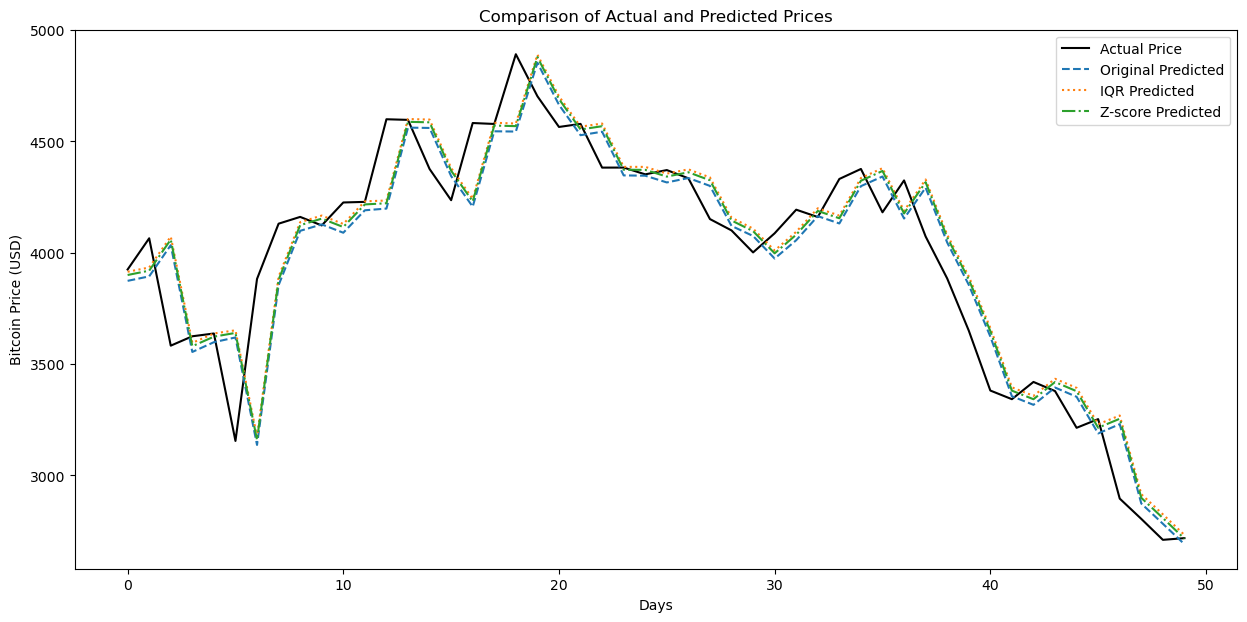

Original Data Metrics: {'MSE': 42872.08490031366, 'MAE': 146.58027828040633, 'RMSE': 207.05575312053915, 'R2': 0.8554080126126344, 'Scaled_MSE': 2.3324657003925648e-05}
IQR Method Metrics: {'MSE': 43845.88250261076, 'MAE': 147.25046001898548, 'RMSE': 209.39408421111318, 'R2': 0.8521237466163203, 'Scaled_MSE': 2.2806638532179735e-05}
Z-score Method Metrics: {'MSE': 43187.54957030939, 'MAE': 146.1904984184129, 'RMSE': 207.81614367105698, 'R2': 0.8543440647385984, 'Scaled_MSE': 2.3154285336024918e-05}


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load the data
df = pd.read_csv('/Users/karina/Documents/NCI Cryptocurrencies Project/Data CSV Cryptocurrencies/Bitcoin_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'] >= '2017-08-01') & (df['Date'] <= '2024-07-09')]

# Cleaning and type conversion
price_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
for col in price_columns:
    df[col] = df[col].str.replace('[^\d\.]', '', regex=True).astype(float)

# Feature selection and target definition
df['Next Close'] = df['Close'].shift(-1)  # Predict the next day price
df = df.dropna()  # Drop rows with NaN values which occur from shifting
X = df[['Close', 'Volume', 'Market Cap']]
y = df['Next Close']

# Function to remove outliers using IQR
def remove_outliers_iqr(X, y):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    condition = (X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))
    mask = ~condition.any(axis=1)
    return X[mask], y[mask]

# Function to remove outliers using Z-score
def remove_outliers_zscore(X, y, threshold=3):
    zs = np.abs(zscore(X))
    mask = (zs < threshold).all(axis=1)
    return X[mask], y[mask]

# Data Scaling and Model Training
def train_and_evaluate(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Split the data into training and testing sets
    X_train, X_test = X_scaled[:-50], X_scaled[-50:]
    y_train, y_test = y[:-50], y[-50:]
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return y_test, predictions, {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Evaluate models
original_metrics = train_and_evaluate(X, y)
iqr_metrics = train_and_evaluate(*remove_outliers_iqr(X, y))
zscore_metrics = train_and_evaluate(*remove_outliers_zscore(X, y))

# Plotting the results
plt.figure(figsize=(15, 7))
plt.plot(range(len(original_metrics[0])), original_metrics[0], label='Actual Price', color='black')
plt.plot(range(len(original_metrics[1])), original_metrics[1], label='Original Predicted', linestyle='--')
plt.plot(range(len(iqr_metrics[1])), iqr_metrics[1], label='IQR Predicted', linestyle=':')
plt.plot(range(len(zscore_metrics[1])), zscore_metrics[1], label='Z-score Predicted', linestyle='-.')
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()


def scale_mse(mse):
    return 1 / (1 + mse)

# Apply scaling to MSE values
original_metrics[2]['Scaled_MSE'] = scale_mse(original_metrics[2]['MSE'])
iqr_metrics[2]['Scaled_MSE'] = scale_mse(iqr_metrics[2]['MSE'])
zscore_metrics[2]['Scaled_MSE'] = scale_mse(zscore_metrics[2]['MSE'])

# Print the updated metrics
print("Original Data Metrics:", original_metrics[2])
print("IQR Method Metrics:", iqr_metrics[2])
print("Z-score Method Metrics:", zscore_metrics[2])


Based on the evaluation metrics provided, the model's performance can be assessed as follows:

1.Original Data Metrics:
   -MSE (Mean Squared Error): 42872.08490031366
   -MAE (Mean Absolute Error): 146.5802782804063
   -RMSE (Root Mean Squared Error): 207.05575312053915
   -R2 (R-squared): 0.8554080126126344
   -Scaled_MSE': 2.3324657003925648e-05
   
  2.IQR Method Metrics:
  -MSE: 43845.88250261076
  -MAE: 147.25046001898548
  -RMSE: 209.39408421111318
  -R2: 0.8521237466163203
  -Scaled_MSE': 2.2806638532179735e-05
  
  3.Z-score Method Metrics:
   -MSE: 43187.54957030939
   -MAE: 146.19049841841129
   -RMSE: 207.81614367105698
   -R2: 0.8543440647385984
   -Scaled_MSE': 2.3154285336024918e-05

The R-squared (R2) values for all three methods are above 0.85, indicating that the model explains a significant portion of the variance in the target variable (Bitcoin price). An R2 value closer to 1 suggests a better fit.